In [44]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

In [45]:
data = pd.read_csv('parkingLot (1).csv')
data = data[data['vehicle_no'].notnull()]
data['timestamp'] = pd.to_datetime(data['timestamp'])
entries = data[data['camera_id'] == 1]
entries['date'] = entries['timestamp'].dt.date
daily_entries = entries.groupby('date').size().reset_index(name='total_entries')
daily_entries['date'] = pd.to_datetime(daily_entries['date'])
daily_entries['date'] = pd.to_datetime(daily_entries['date'])
train_size = int(len(daily_entries) * 0.75)
train, test = daily_entries[:train_size], daily_entries[train_size:]

C:\Users\asyed\AppData\Local\Temp\ipykernel_2372\2354690106.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entries['date'] = entries['timestamp'].dt.date


In [64]:
model = ARIMA(train['total_entries'].dropna(), order=(3, 1, 1), seasonal_order=(2, 1, 1, 7), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()
#predictions
test_pred=model_fit.predict(start=test.index[0], end=test.index[-1])

# Forecast for the next 7 days
last_day = (daily_entries['date']).iloc[-1]
print(last_day)

future_days = (pd.date_range(start=last_day, periods=7,freq='D').date)
forecast = model_fit.forecast(steps=7)

forecast_data=pd.DataFrame({'dates':future_days,'Pred entries':forecast})
print(forecast_data['Pred entries'])

2024-11-13 00:00:00
47    807.108467
48    871.919938
49    811.137401
50    812.967244
51    771.670131
52    869.229497
53    852.257854
Name: Pred entries, dtype: float64


In [65]:
mase =mean_absolute_scaled_error(test['total_entries'].iloc[:], test_pred, y_train=train['total_entries'].iloc[:])
print(f"Mean Absolute Scaled Error (MASE): {mase}")
        
mape = np.mean(np.abs((test['total_entries'].iloc[:] - test_pred) / test['total_entries'].iloc[:])) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Scaled Error (MASE): 0.6440560293512054
Mean Absolute Percentage Error (MAPE): 5.576646286292907%


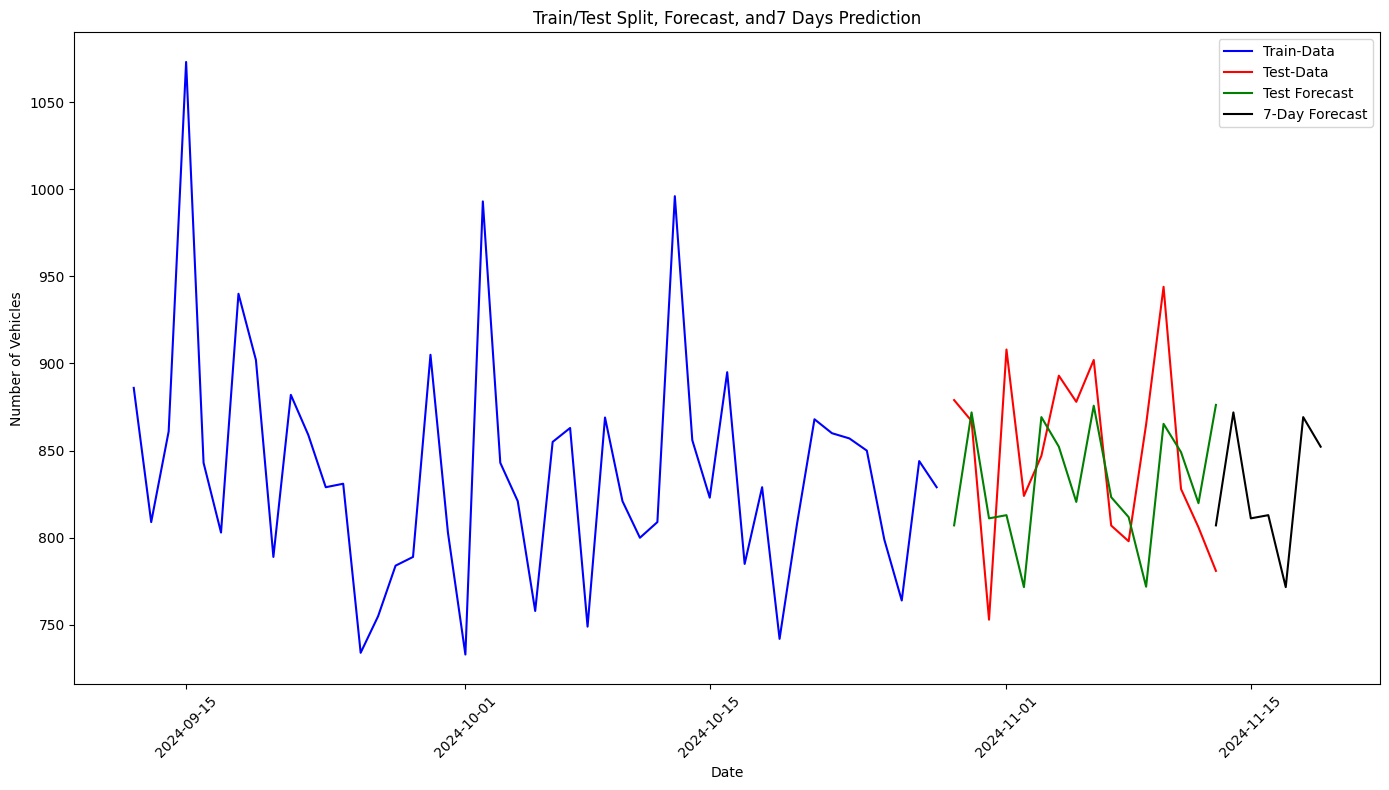

In [66]:
plt.figure(figsize=(14, 8))
plt.plot(train['date'].iloc[:], train['total_entries'].iloc[:], label='Train-Data', color='blue')
plt.plot(test['date'].iloc[:], test['total_entries'].iloc[:], label='Test-Data', color='red')
plt.plot(test['date'].iloc[:], test_pred, label='Test Forecast', color='green')
plt.plot(forecast_data['dates'], forecast_data['Pred entries'], label='7-Day Forecast', color='black')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.title('Train/Test Split, Forecast, and7 Days Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()